In [1]:
from TMSAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration
from TMSAnalysis.TMSUtilities.GetCuts import Cut
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import uproot, glob, time
import pandas as pd
import numpy as np

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 15

analysis_config = StruckAnalysisConfiguration.StruckAnalysisConfiguration()
analysis_config.GetRunParametersFromFile('../config/Run_Parameters_Xe_Run29.csv')
sampling_time = analysis_config.run_parameters['Sampling Period [ns]']/1.e3
trigger_time = analysis_config.run_parameters['Pretrigger Length [samples]']

In [2]:
path_to_reduced = '/p/lustre1/jacopod/29th/TMS_analysis/'
!ls $path_to_reduced

20200207_PreRecirculation    20200212_RecoverY17X19
20200210_AfterRecirculation  20200213_AfterRnInjection
20200211_AfterRecirculation  20200213_DuringRnInjection
20200212_RecirculationOff    notebook


In [3]:
folder = '20200212_RecirculationOff'
df = pd.read_hdf(path_to_reduced + folder + '/reduced_added.h5')
for k in df.keys():
    print(k)

ChannelPositions
ChannelTypes
Event
File
NumSiPMChannelsHit
NumTileChannelsHit
NumXTileChannelsHit
NumYTileChannelsHit
SiPM 1-3 Baseline
SiPM 1-3 Baseline RMS
SiPM 1-3 Pulse Area
SiPM 1-3 Pulse Height
SiPM 1-3 Pulse Time
SiPM 1-3 T10
SiPM 1-3 T20
SiPM 1-3 T5
SiPM 1-3 T80
SiPM 1-3 T90
TileStrip X1-12 Baseline
TileStrip X1-12 Baseline RMS
TileStrip X1-12 Charge Energy
TileStrip X1-12 Drift Time
TileStrip X1-12 T10
TileStrip X1-12 T25
TileStrip X1-12 T50
TileStrip X1-12 T90
TileStrip X13 Baseline
TileStrip X13 Baseline RMS
TileStrip X13 Charge Energy
TileStrip X13 Drift Time
TileStrip X13 T10
TileStrip X13 T25
TileStrip X13 T50
TileStrip X13 T90
TileStrip X14 Baseline
TileStrip X14 Baseline RMS
TileStrip X14 Charge Energy
TileStrip X14 Drift Time
TileStrip X14 T10
TileStrip X14 T25
TileStrip X14 T50
TileStrip X14 T90
TileStrip X15 Baseline
TileStrip X15 Baseline RMS
TileStrip X15 Charge Energy
TileStrip X15 Drift Time
TileStrip X15 T10
TileStrip X15 T25
TileStrip X15 T50
TileStrip X15 T90

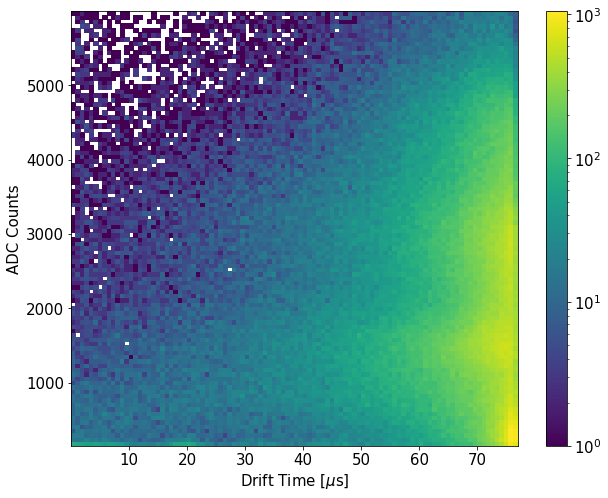

In [4]:
DriftTime = (df['TimeOfMaxChannel'] - trigger_time)*sampling_time
cut_array = ['DriftTime>0', 'DriftTime<77',\
             'TotalTileEnergy>150', 'TotalTileEnergy<6000','NumTileChannelsHit>1']
derived_dict = {'DriftTime':DriftTime}
cut = Cut(cut_array,df,derived_dict)
mask = cut.mask
plt.hist2d(DriftTime.loc[mask], df['TotalTileEnergy'].loc[mask], bins=100, norm=LogNorm())
plt.xlabel('Drift Time [$\mu$s]')
plt.ylabel('ADC Counts')
plt.colorbar()

Here I look how the events showing the 207Bi spectrum look like on each channel X13, X19 and Y17 are not active (recovered at the fifth run). No channel shows spectrum like features apart from the Compton edge in the big bundles. Since no clear peak is showing, this suggests that SS events become broader due to diffusion. Lastly as cross-check, I plot the total spectrum, summing up the energies from each channel

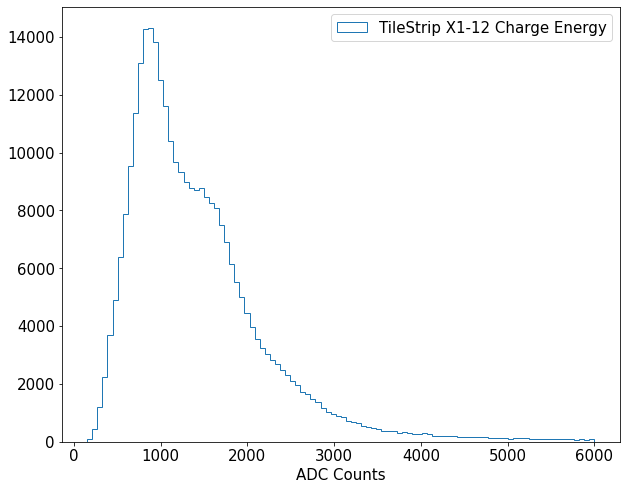

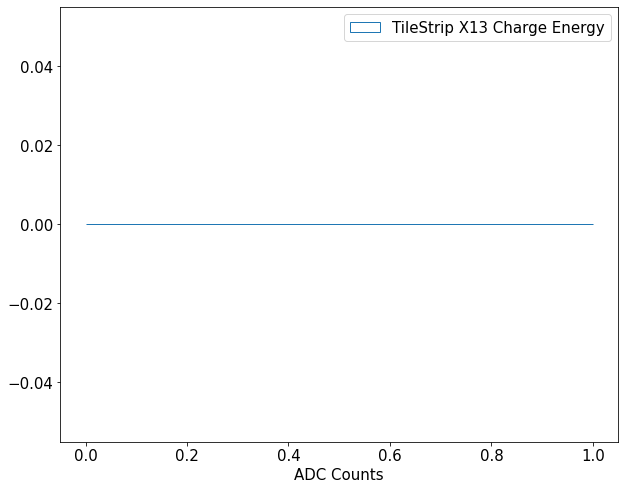

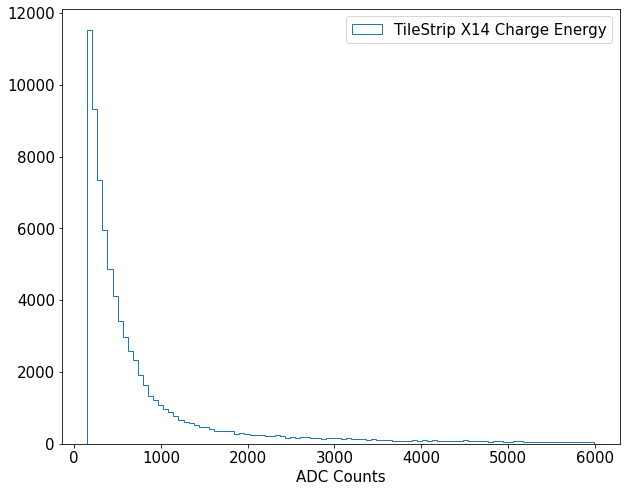

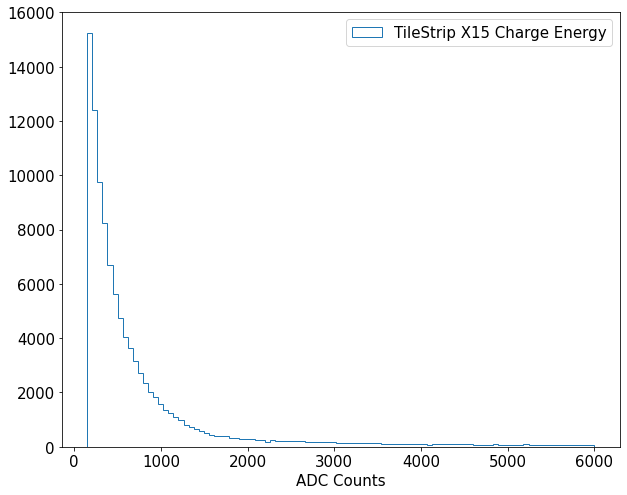

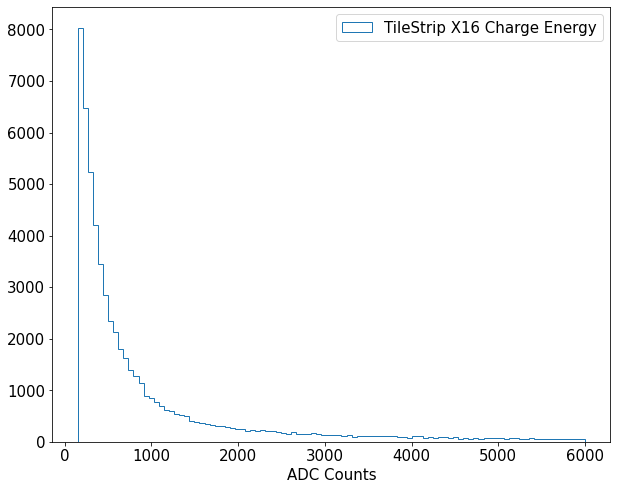

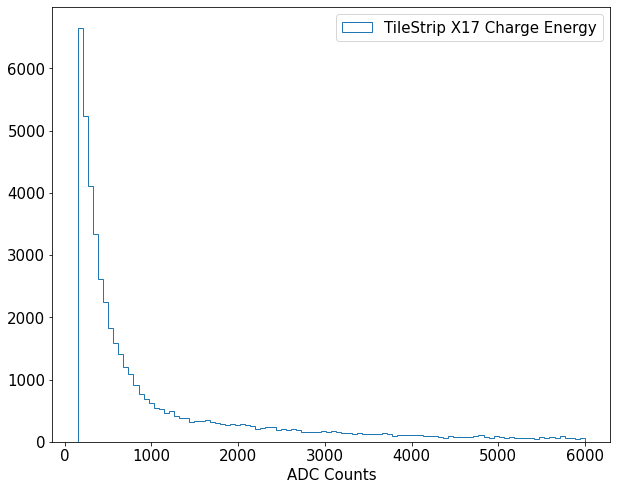

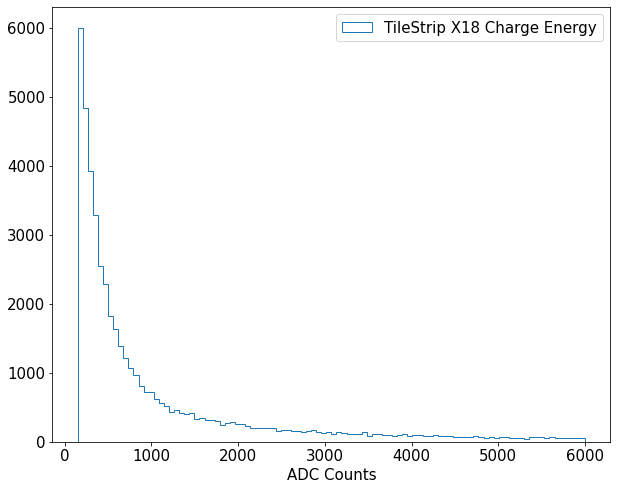

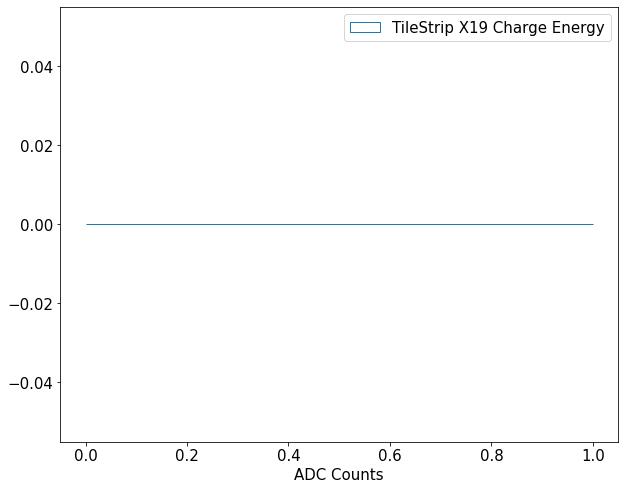

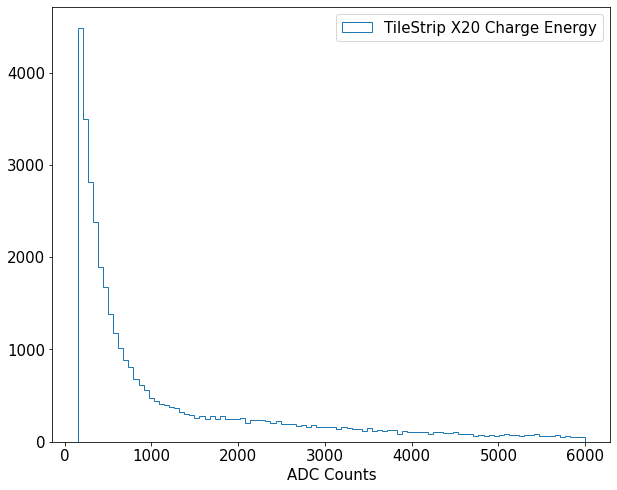

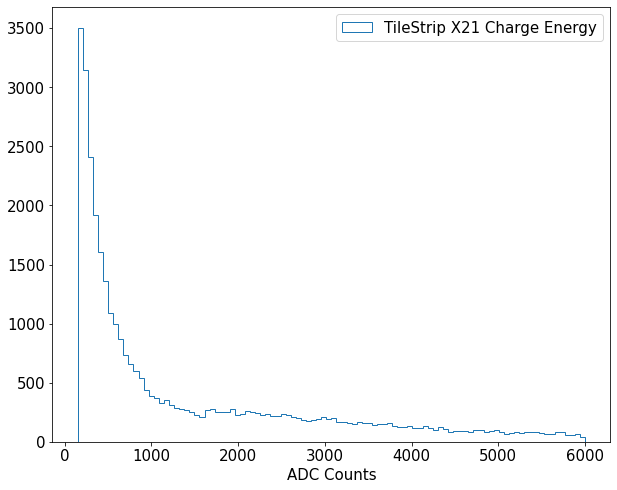

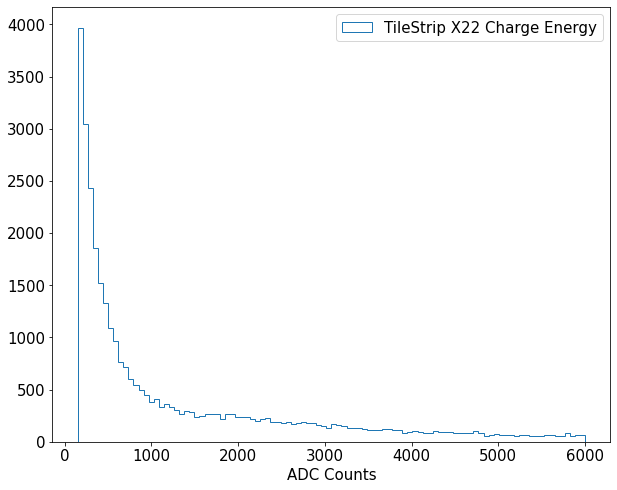

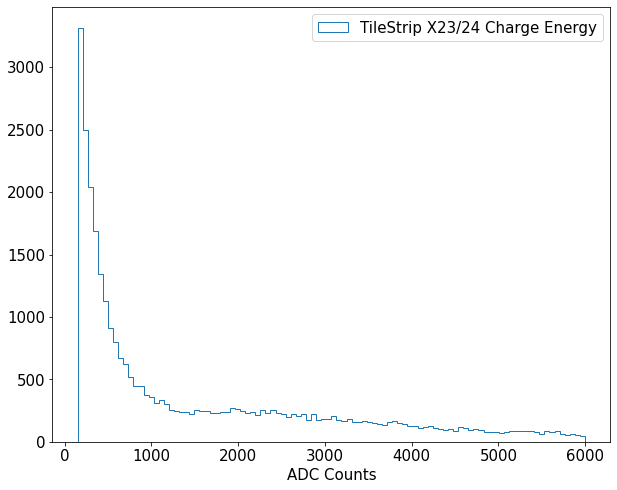

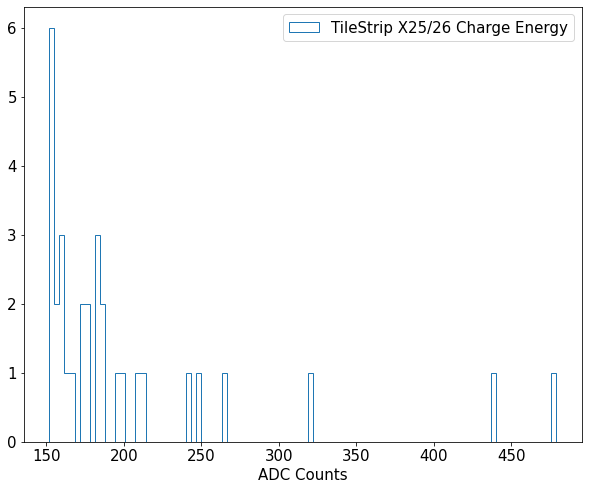

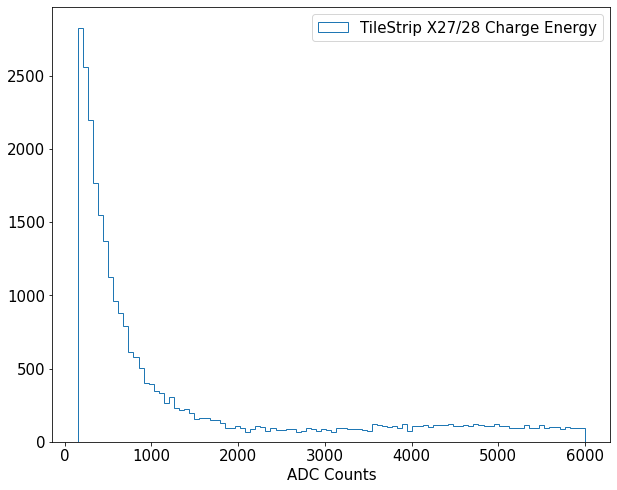

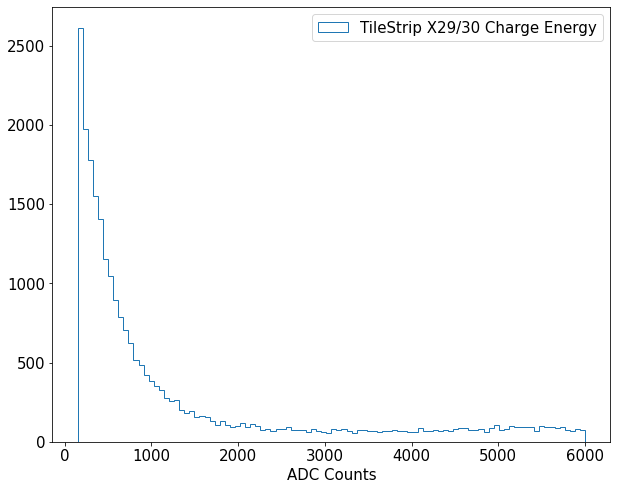

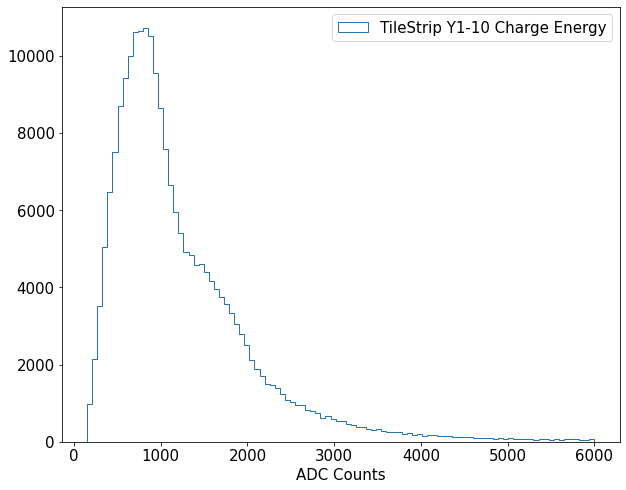

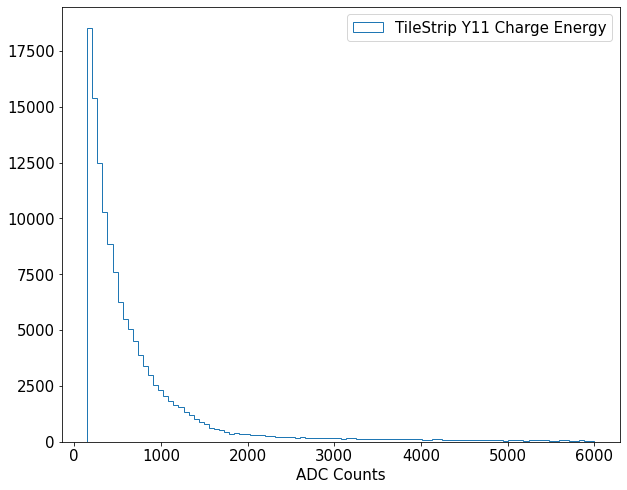

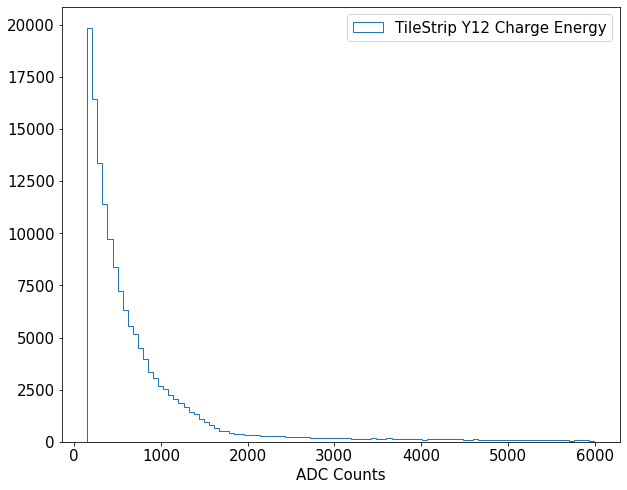

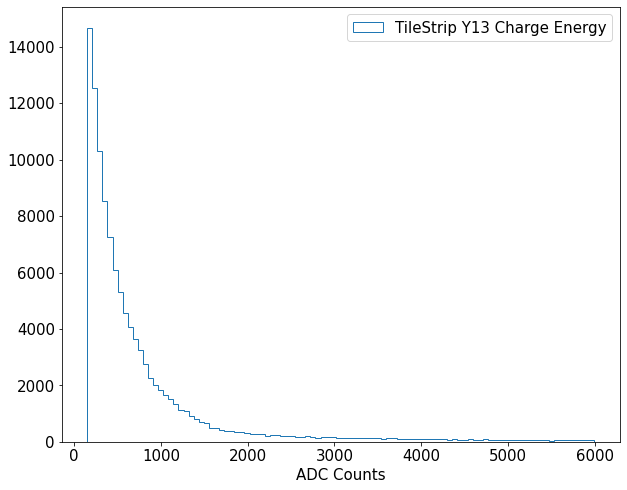

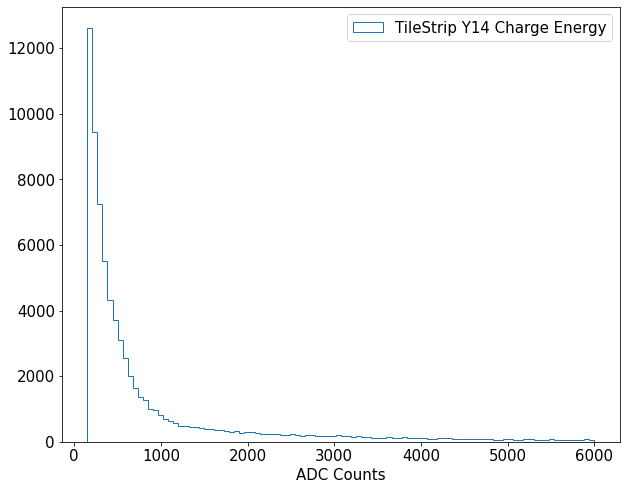

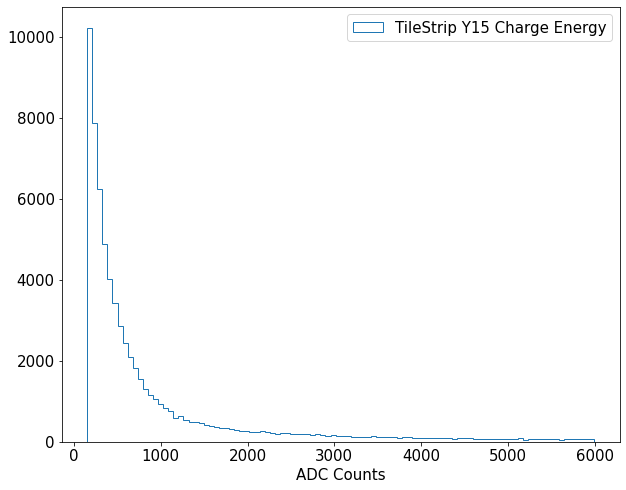

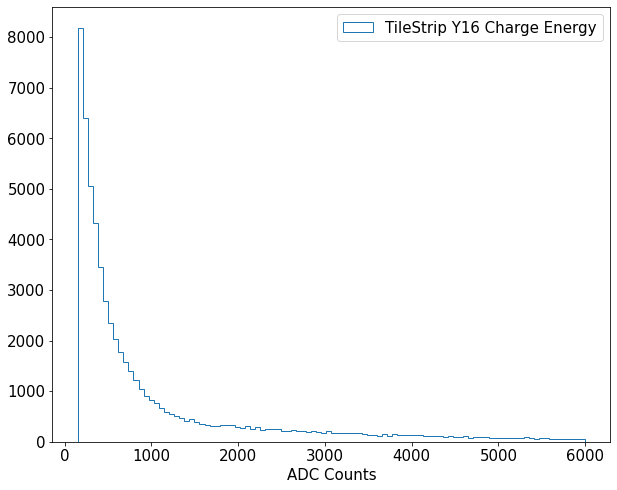

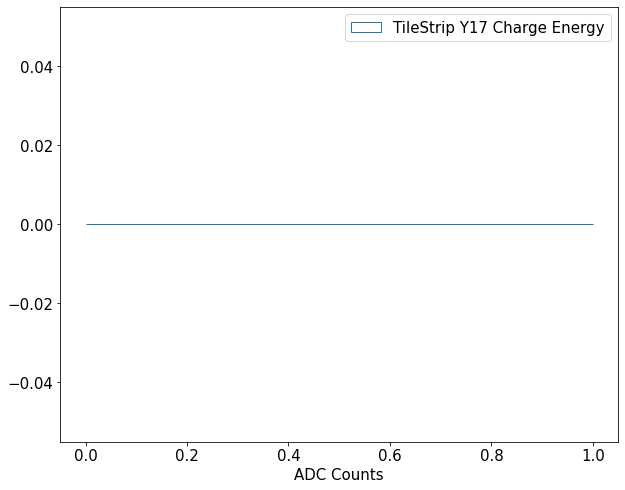

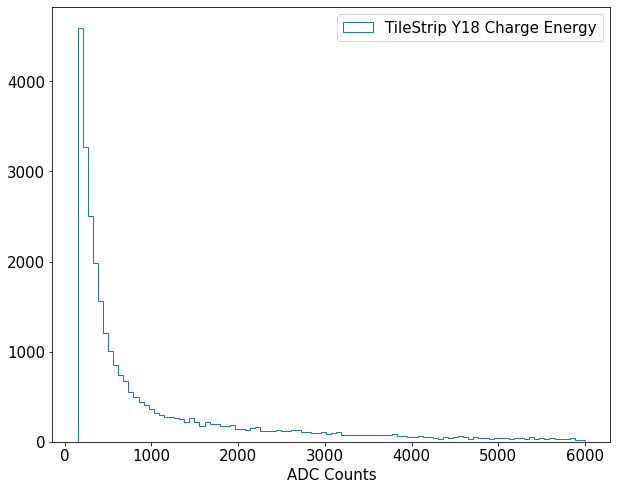

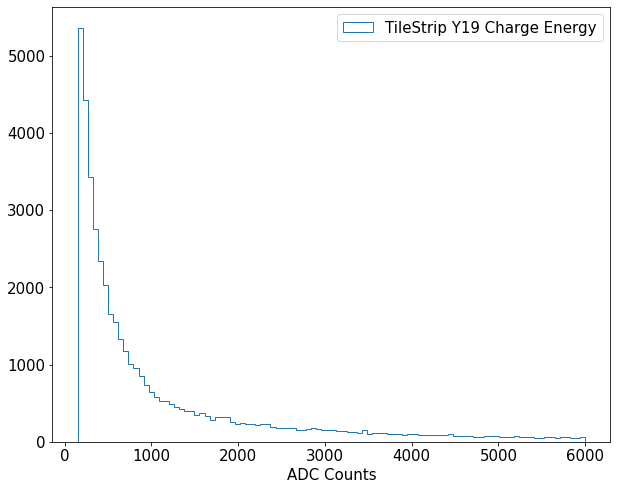

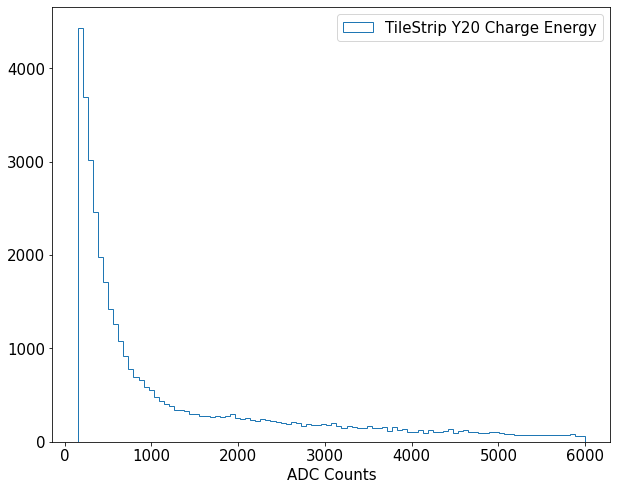

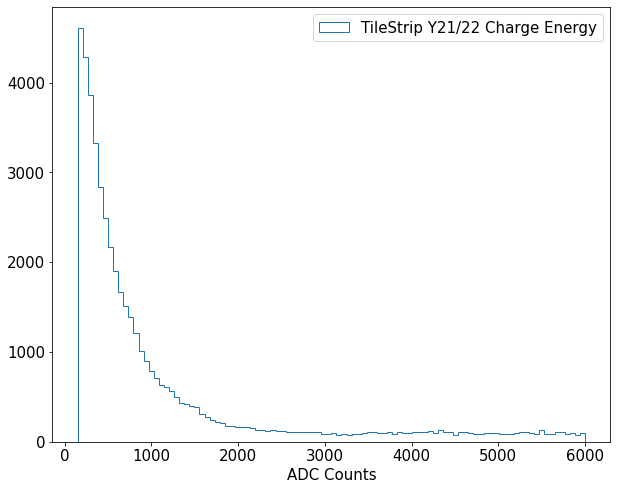

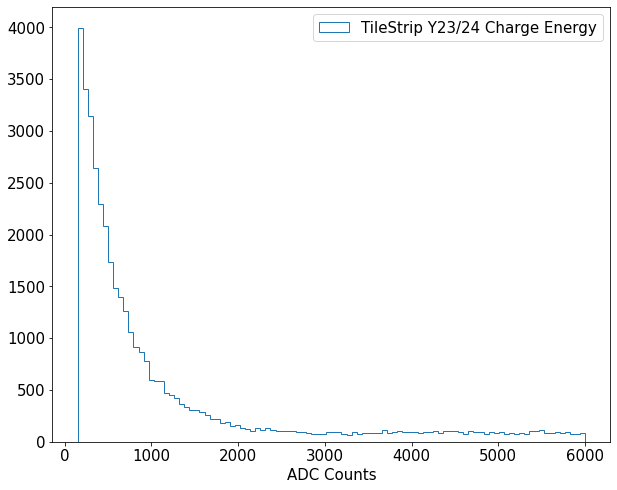

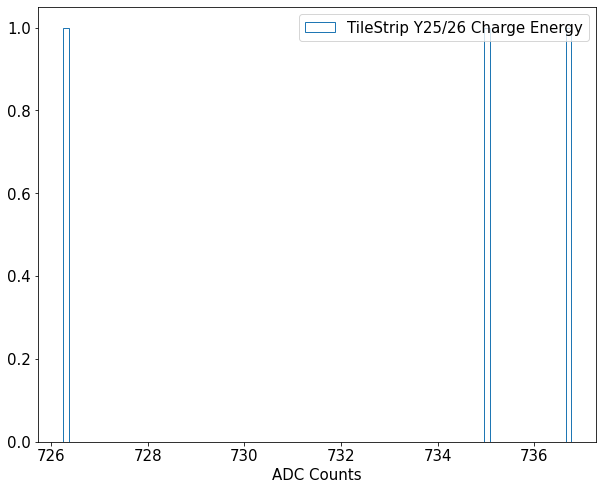

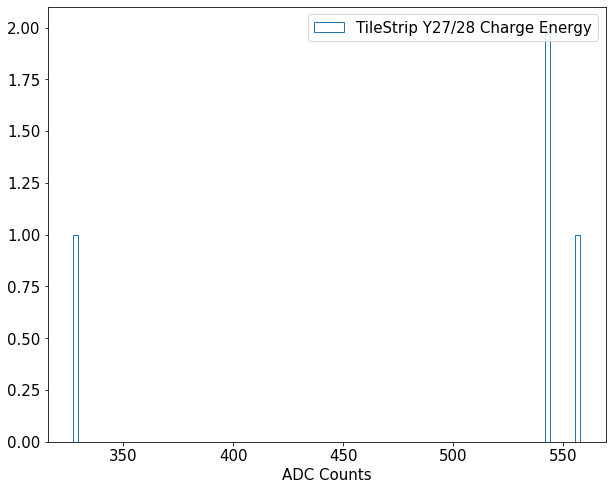

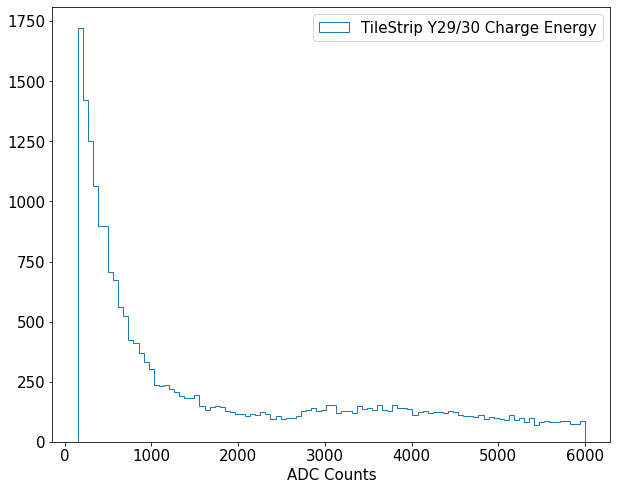

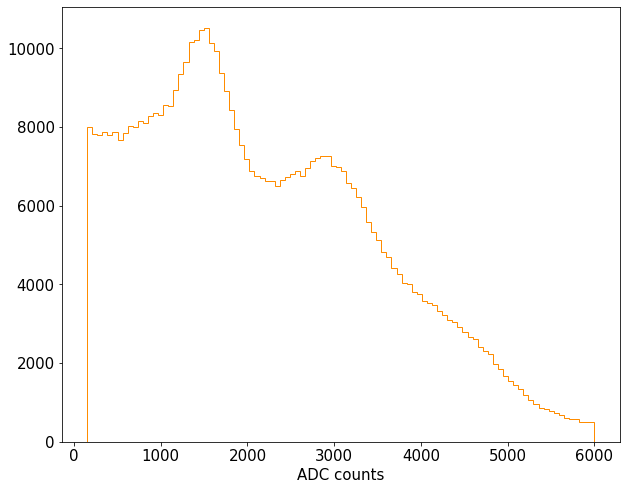

In [5]:
total_df = []
for k in df.keys():
    if not (k.startswith('TileStrip') and k.endswith('Charge Energy')):
        continue
    cut_array1 = ['{}>150'.format(k),'{}<6000'.format(k),'DriftTime>0', 'DriftTime<77']
    cut1 = Cut(cut_array1,df,derived_dict)
    mask1 = cut1.mask
    plt.hist(df['{}'.format(k)].loc[mask1],bins=100,histtype='step',label=k)
    plt.legend()
    plt.xlabel('ADC Counts')
    plt.show()
    total_df.append(df['{}'.format(k)].loc[mask])

total_spectrum = np.sum(np.asarray(total_df),axis=0)
    
plt.hist(total_spectrum,bins=100,histtype='step',color='darkorange')
plt.xlabel('ADC counts')
plt.show()

here I bundle up channels (X and Y-wise) to have all approximately the same width (~10 strips per bundle). Still no clear peak in the different spectra. Bundles X23/X30 and Y21/30 are most likely the furthest from the source

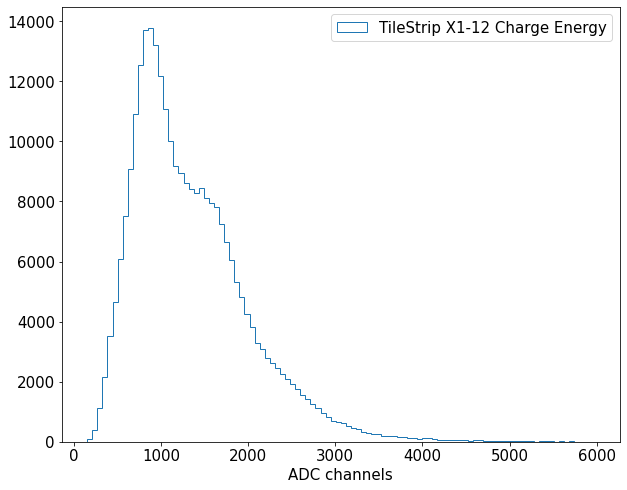

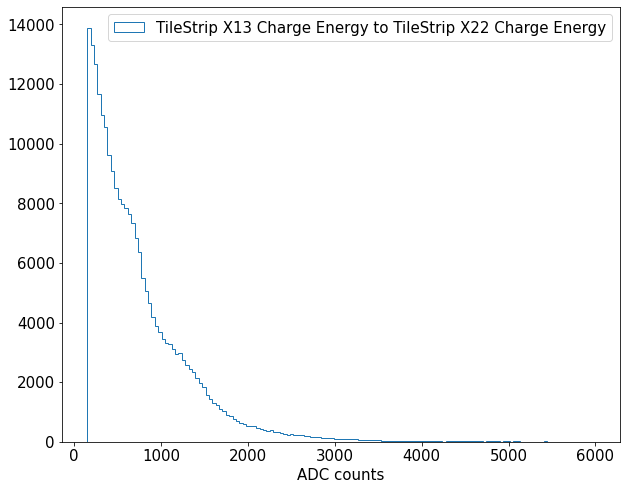

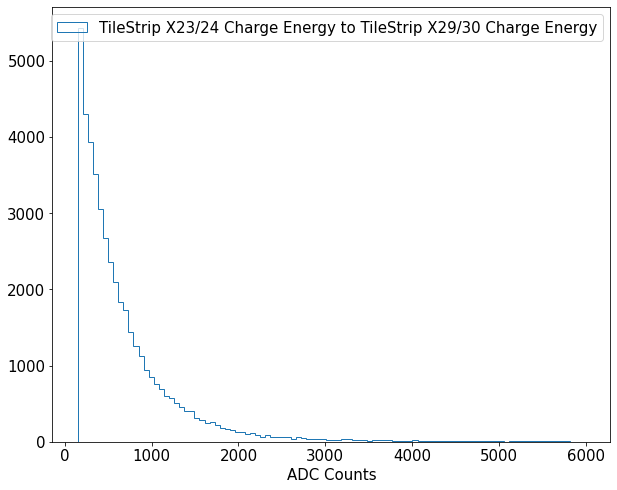

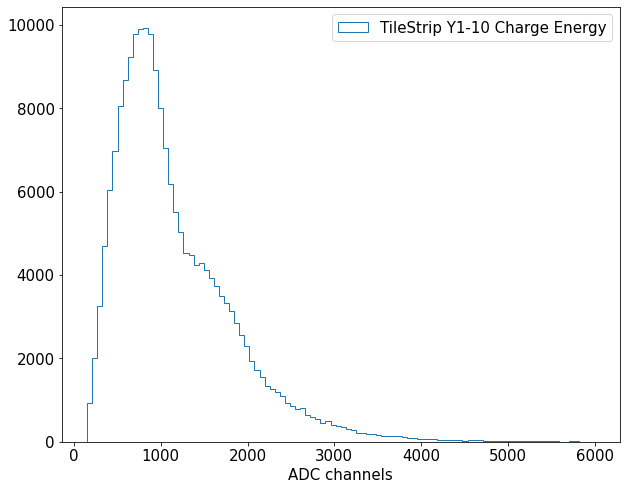

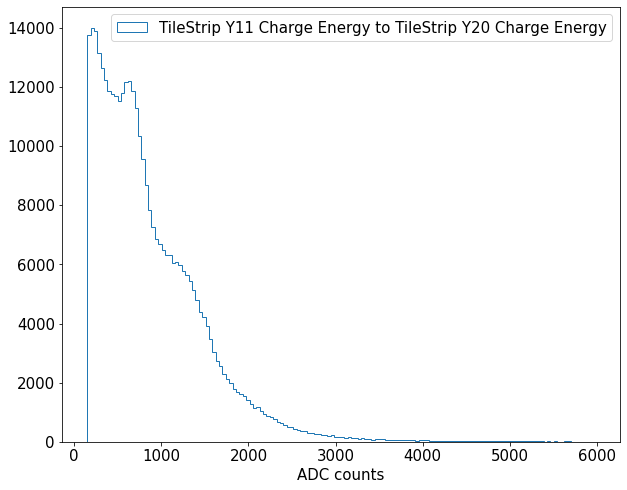

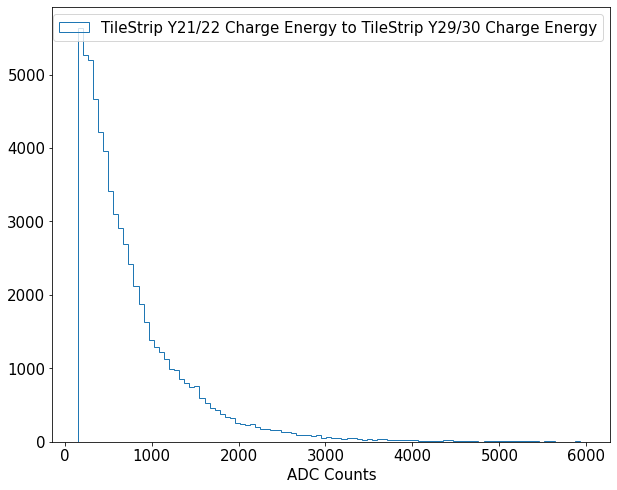

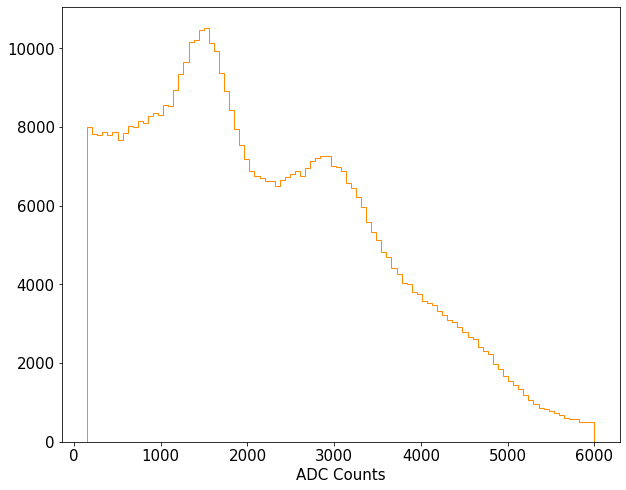

In [6]:
i = True
j = True
lower_threshold = 150
bundle = []
double_df = []
signle_df = []
 
for k in df.keys():
    if not (k.startswith('TileStrip') and k.endswith('Charge Energy')):
        continue
    
    if '-' in k:
        bundle_X = bundle
        bundle = df['{}'.format(k)].loc[mask]
        plt.hist(bundle[bundle>lower_threshold],bins=100,histtype='step',label=k)
        plt.legend()
        plt.xlabel('ADC channels')
        plt.show()
        
    elif '/' in k:     
        if i:
            first_label = k
            i = False    
            try:
                double_spectrum_X = double_spectrum
            except NameError:
                pass
            double_df = []

        double_df.append(df['{}'.format(k)].loc[mask])

        if k == 'TileStrip X29/30 Charge Energy' or k == 'TileStrip Y29/30 Charge Energy':
            i = True
            double_spectrum = np.sum(np.asarray(double_df),axis=0)
            plt.hist(double_spectrum[double_spectrum>lower_threshold],bins=100,histtype='step',\
                     label='{} to {}'.format(first_label,k))
            plt.legend()
            plt.xlabel('ADC Counts')
            plt.show()
        
    else:
        if j:
            first_label = k
            j = False
            try:
                signle_spectrum_X = signle_spectrum
            except NameError:
                pass
            signle_df = []

        signle_df.append(df['{}'.format(k)].loc[mask])
                
        if k == 'TileStrip X22 Charge Energy' or k == 'TileStrip Y20 Charge Energy':
            j = True
            signle_spectrum = np.sum(np.asarray(signle_df),axis=0)
            plt.hist(signle_spectrum[signle_spectrum>lower_threshold],bins=lower_threshold,histtype='step',\
                     label='{} to {}'.format(first_label,k))
            plt.legend()
            plt.xlabel('ADC counts')
            plt.show()

total_spectrum_bundle = pd.DataFrame(np.asarray([bundle_X.values, bundle.values,\
                                      signle_spectrum_X, signle_spectrum,\
                                      double_spectrum_X, double_spectrum]).T,\
                                    columns = ['10X','10Y','1X','1Y','2X','2Y'])
plt.hist(total_spectrum_bundle.sum(axis=1),bins=100,histtype='step',\
        color='darkorange')
plt.xlabel('ADC Counts')
plt.show()

Spectra are shown for the different XY combination of 10 ganged strips (the inset displays where the pixel is located in tile), the 570keV peak starts to appear, the 1067keV is still not contained in this area size. When a bigger bundle (20x20) is shown full spectrum appears distintively. The source is most likely located in 10X,1Y close to 10X,10Y and 1X,1Y

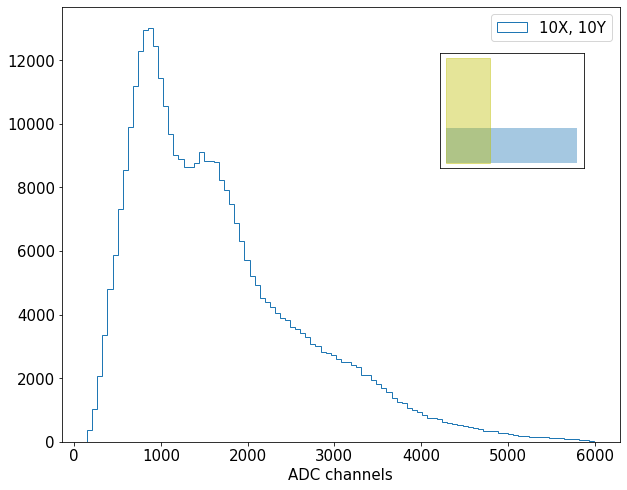

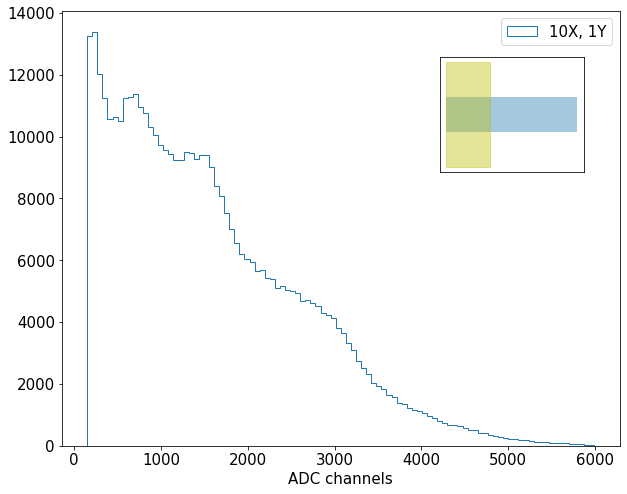

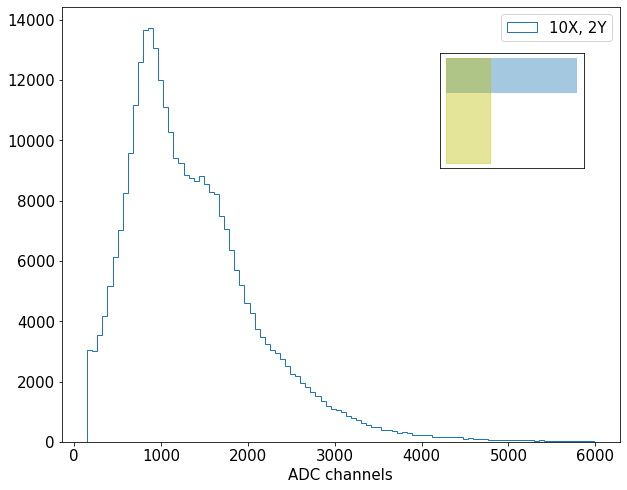

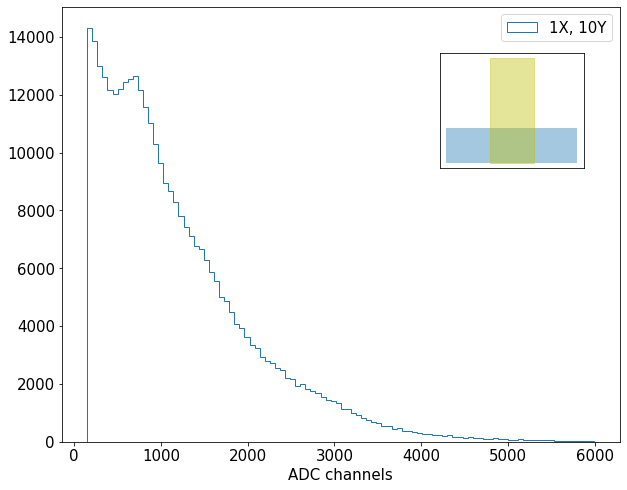

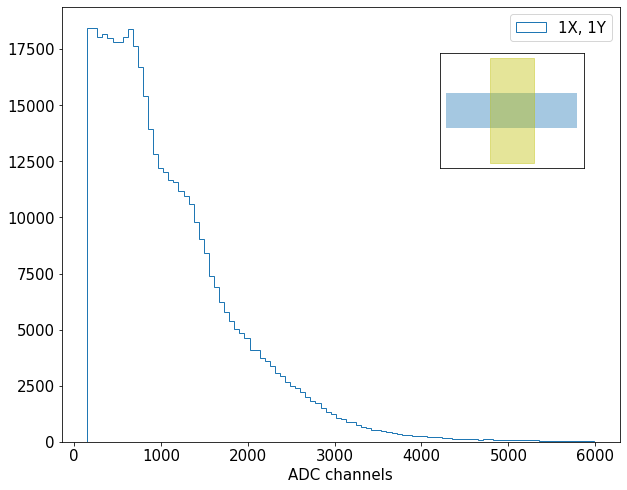

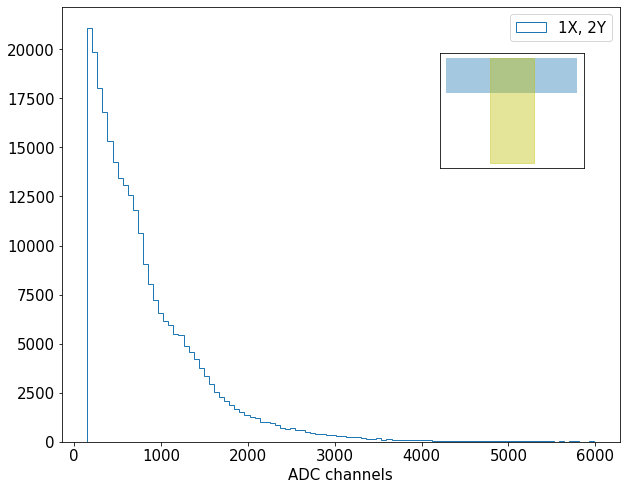

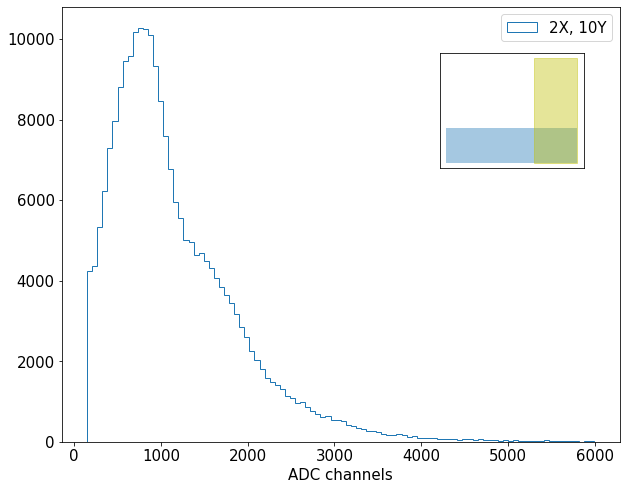

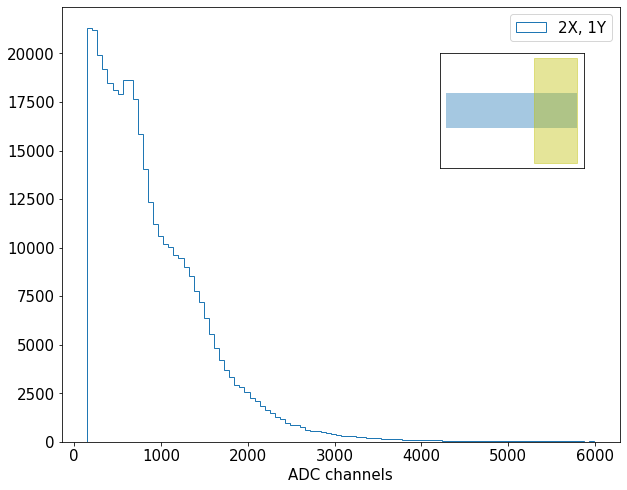

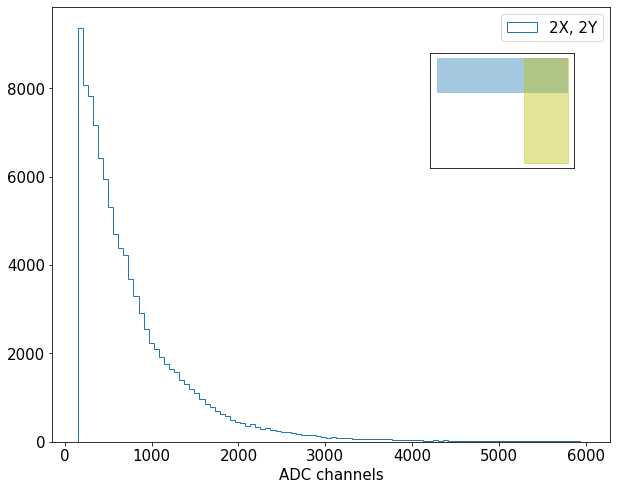

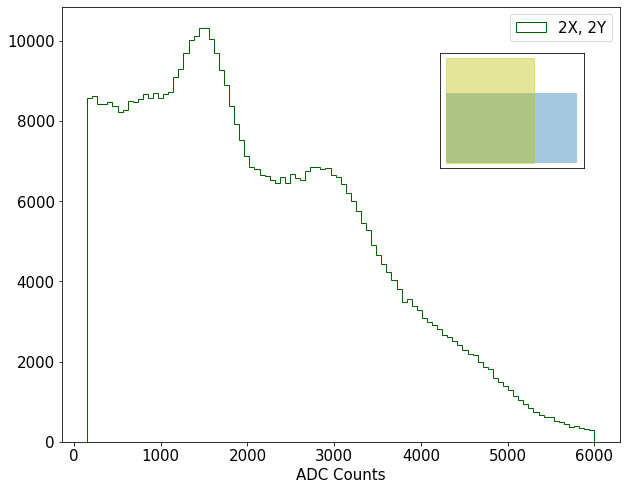

In [7]:
import itertools
for (X,Y),(x,y) in zip(itertools.product(total_spectrum_bundle.keys()[::2],total_spectrum_bundle.keys()[1::2]),\
                   itertools.product(range(3),range(3))):
    square = total_spectrum_bundle['{}'.format(X)] + total_spectrum_bundle['{}'.format(Y)]
    plt.hist(square[square>lower_threshold],bins=100,histtype='step',label='{}, {}'.format(X,Y))
    plt.legend()
    plt.xlabel('ADC channels')
    plt.axes([.65, .6, .2, .2])
    horizontal_band_x = [0,3]
    horizontal_band_y1 = y
    horizontal_band_y2 = y + 1
    vertical_band_x = [x,x + 1]
    vertical_band_y1 = 0
    vertical_band_y2 = 3
    plt.fill_between(horizontal_band_x,horizontal_band_y1,horizontal_band_y2,alpha=0.4)
    plt.fill_between(vertical_band_x,vertical_band_y1,vertical_band_y2,alpha=0.4,color='y')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
big_square = total_spectrum_bundle['10X'] + total_spectrum_bundle['10Y'] +\
            total_spectrum_bundle['1X'] + total_spectrum_bundle['1Y']
plt.hist(big_square[big_square>lower_threshold],bins=100,histtype='step',label='{}, {}'.format(X,Y),color='darkgreen')
plt.legend()
plt.xlabel('ADC Counts')
plt.axes([.65, .6, .2, .2])
horizontal_band_x = [0,3]
horizontal_band_y1 = 0
horizontal_band_y2 = 2
vertical_band_x = [0,2]
vertical_band_y1 = 0
vertical_band_y2 = 3
plt.fill_between(horizontal_band_x,horizontal_band_y1,horizontal_band_y2,alpha=0.4)
plt.fill_between(vertical_band_x,vertical_band_y1,vertical_band_y2,alpha=0.4,color='y')
plt.xticks([])
plt.yticks([])
plt.show()

here I compare the multiplicity and drift time of the events in the whole spectrum with the ones in the first peak and in the second peak. The red histograms represent events with a number of x strips that differ from the number of y strips not more than one 

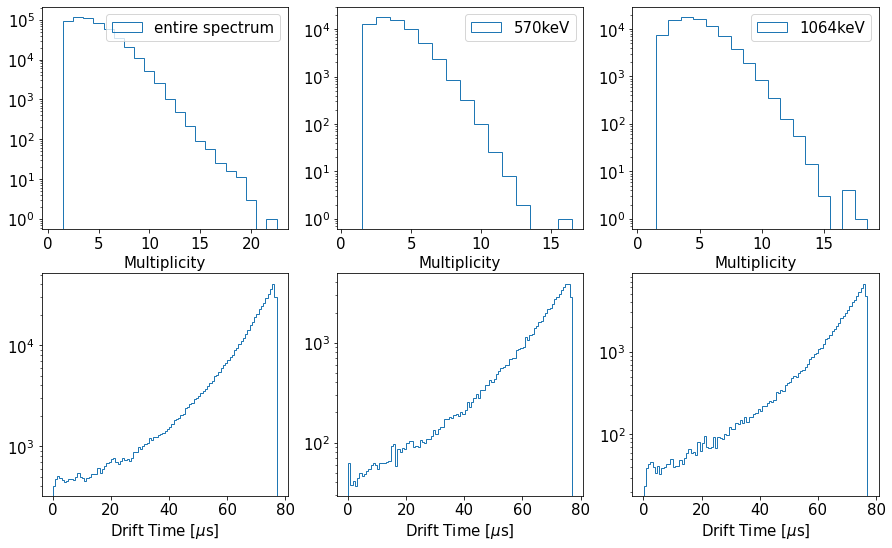

In [8]:
fig, ax = plt.subplots(2,3, figsize=(15,9))
limits = [['150','6000'],['1100','1500'],['2300','3000']]
labels = ['entire spectrum','570keV','1064keV']
cut_array = ['DriftTime>0', 'DriftTime<77','NumTileChannelsHit>1']
for i in range(3):
    cut_array = cut_array[:3]
    cut_array += ['TotalTileEnergy>{}'.format(limits[i][0]), 'TotalTileEnergy<{}'.format(limits[i][1])]
    cut = Cut(cut_array,df,derived_dict)
    mask = cut.mask
    bin_limits = np.arange(max(df['NumTileChannelsHit'].loc[mask])+1) + 0.5
    ax[0,i].hist(df['NumTileChannelsHit'].loc[mask],bins=bin_limits,histtype='step',log=True,label=labels[i])
    ax[0,i].set_xlabel('Multiplicity')
    ax[0,i].legend()
    ax[1,i].hist(DriftTime.loc[mask],bins=100,histtype='step',log=True,label=labels[i])
    ax[1,i].set_xlabel('Drift Time [$\mu$s]')